In [28]:
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.signal import find_peaks, peak_prominences
from scipy.ndimage import gaussian_filter1d
from scipy.stats import landau

FADC_BIN_WIDTH = 1


In [29]:
def load_pmt(input_file,pmtname, minnpe = 0.): 
    data=pd.read_csv(input_file, sep ='\t',header=None)
    data.columns = ["num","id", "energy", "pmt1", "pmt2", "pmt3", "pmt4", "pmt1_FADC", "pmt2_FADC", "pmt3_FADC", "pmt4_FADC"]
    pmt_em = data.query("id == 1 or id == 2 or id == -2")[pmtname]
    pmt_mu = data.query("id == 3 or id == -3")[pmtname]

    pmt_mu = np.asarray(pmt_mu[pmt_mu >= minnpe])
    pmt_em = np.asarray(pmt_em[pmt_em >= minnpe])
    pmt_tot = np.concatenate((pmt_mu,pmt_em))
    
    return pmt_em, pmt_mu, pmt_tot

def load_top_sum_fadc_pmt(input_file, minnpe = 0.): 
    data=pd.read_csv(input_file, sep ='\t',header=None)
    data.columns = ["num","id", "energy", "pmt1", "pmt2", "pmt3", "pmt4", "pmt1_FADC", "pmt2_FADC", "pmt3_FADC", "pmt4_FADC"]
    pmt_em_1 = data.query("id == 1 or id == 2 or id == -2")['pmt1_FADC']
    pmt_mu_1 = data.query("id == 3 or id == -3")['pmt1_FADC']
    pmt_em_2 = data.query("id == 1 or id == 2 or id == -2")['pmt2_FADC']
    pmt_mu_2 = data.query("id == 3 or id == -3")['pmt2_FADC']
    pmt_em_3 = data.query("id == 1 or id == 2 or id == -2")['pmt3_FADC']
    pmt_mu_3 = data.query("id == 3 or id == -3")['pmt3_FADC']

    pmt_mu_1 = np.asarray(pmt_mu_1[pmt_mu_1 >= minnpe])
    pmt_em_1 = np.asarray(pmt_em_1[pmt_em_1 >= minnpe])
    pmt_tot_1 = np.concatenate((pmt_mu_1,pmt_em_1))

    pmt_mu_2 = np.asarray(pmt_mu_2[pmt_mu_2 >= minnpe])
    pmt_em_2 = np.asarray(pmt_em_2[pmt_em_2 >= minnpe])
    pmt_tot_2 = np.concatenate((pmt_mu_2,pmt_em_2))

    pmt_mu_3 = np.asarray(pmt_mu_3[pmt_mu_3 >= minnpe])
    pmt_em_3 = np.asarray(pmt_em_3[pmt_em_3 >= minnpe])
    pmt_tot_3 = np.concatenate((pmt_mu_3,pmt_em_3))

    pmt_tot = np.concatenate((pmt_tot_1, pmt_tot_2, pmt_tot_3))
    
    return pmt_tot

In [30]:

# Gaussian function for fitting
def gaussian(x, A, mu, sigma):
    return A * norm.pdf(x, mu, sigma)

def landau_func(x, A, mu, sigma): 
    return A * landau.pdf(x,mu,sigma)

def pol_2(x, p0, p1, p2): 
    return p0 * x * x + p1 * x + p2 


# Define funciton to perform Gaussian fit of the peak 
fadc_bins = np.arange(0,1000,1)

def gaussian_fit(input_array, fadc_bins, range_low, range_hi, low_count_threshold):

    # Build histogram ignoring low FADC counts (to remove em peak)
    entries, bin = np.histogram(input_array[input_array > low_count_threshold], bins=fadc_bins)
    arg_fadc_muon_mx = np.argmax(entries)
    print('FADC bin with largest entries ',fadc_bins[arg_fadc_muon_mx])

    fadc_low = fadc_bins[arg_fadc_muon_mx] - range_low
    fadc_hi = fadc_bins[arg_fadc_muon_mx] + range_hi

    range = [fadc_low, fadc_hi]

    # Perform fit on histogram with restricted range 
    array_to_fit = input_array[(input_array > fadc_low) & (input_array < fadc_hi)]

    entries_fit, bin_fit = np.histogram(array_to_fit, bins=fadc_bins)
    sigma_entries_fit = np.sqrt(entries_fit)
    sigma_entries_fit[sigma_entries_fit == 0] = 1e-6  # avoid zero division

    bin_centers = (bin_fit[:-1] + bin_fit[1:]) / 2.
    bin_width = bin_fit[1] - bin_fit[0] 

    # First guess for Gaussian parameters 
    p0 = [max(array_to_fit), np.mean(array_to_fit), 2.5*np.std(array_to_fit)]
    print('\nFirst guess ',p0)
    bounds = ([0, -np.inf, 1e-6], [np.inf, np.inf, np.inf])

    #array_to_fit = input_array[(input_array > 1.5*np.std(array_to_fit)) & (input_array < 2.5*np.std(array_to_fit))]

    #popt, pcov = curve_fit(gaussian, bin_centers, entries_fit, p0=p0, bounds = bounds, sigma = sigma_entries_fit, absolute_sigma=True)
    popt, pcov = curve_fit(gaussian, bin_centers, entries_fit, p0=p0)

    # Extract parameter estimates
    A_fit, mu_fit, sigma_fit = popt

    # Compute standard errors (uncertainties)
    perr = np.sqrt(np.diag(pcov))
    A_err, mu_err, sigma_err = perr


    return popt, perr, range 


def pol2_fit(input_array, fadc_bins, range_low, range_hi, low_count_threshold):

    # Build histogram ignoring low FADC counts (to remove em peak)
    entries, bin = np.histogram(input_array[input_array > low_count_threshold], bins=fadc_bins)
    arg_fadc_muon_mx = np.argmax(entries)
    print('\nFADC bin with largest entries ',fadc_bins[arg_fadc_muon_mx])

    fadc_low = fadc_bins[arg_fadc_muon_mx] - range_low
    fadc_hi = fadc_bins[arg_fadc_muon_mx] + range_hi

    range = [fadc_low, fadc_hi]

    # Perform fit on histogram with restricted range 
    array_to_fit = input_array[(input_array > fadc_low) & (input_array < fadc_hi)]

    fadc_bins_fit = np.arange(fadc_low, fadc_hi+1, FADC_BIN_WIDTH )

    entries_fit, bin_fit = np.histogram(array_to_fit, bins=fadc_bins_fit)

    bin_centers = (bin_fit[:-1] + bin_fit[1:]) / 2.
    bin_width = bin_fit[1] - bin_fit[0] 

    # First guess for pol2 parameters 
    p0 = np.polyfit(bin_centers, entries_fit, deg=2)
    print('First guess ',p0)

    popt, pcov = curve_fit(pol_2, bin_centers, entries_fit, p0=p0)

    # Compute standard errors (uncertainties)
    perr = np.sqrt(np.diag(pcov))

    #popt = p0

    return popt, perr, range 

In [31]:
# Function to find minumum in a range defined by a lower limit and the peak maximum 

def find_valley(input_array, low_threshold, peak_position): 
    print('Looking for minimum between ',low_threshold,' and ', peak_position)
    array_formin = input_array[(input_array >low_threshold) & (input_array < peak_position)]

    bins = np.arange(low_threshold+2, int(peak_position),FADC_BIN_WIDTH)

    entries, bin = np.histogram(array_formin, bins=bins)
    fadc_min = np.argmin(entries)
    return bin[fadc_min]



FADC bin with largest entries  28
First guess  [   -32.42525856   1968.13720103 -27715.31635827]
Result of Gaussian fit
p0 = -32.42525856496441  +- 4.215156601906379
p1 = 1968.1372010342563  +- 257.63308775163375
p2 = -27715.316358274024  +- 257.63308775163375
Peak position is:  30.34882816880348
Peak width is :  11.515790802756356
Looking for minimum between  10  and  30.34882816880348
Found minimum at  12 

Width at peak minimum:  16.281999723796318 


FADC bin with largest entries  35
First guess  [-2.60545410e+01  1.95936558e+03 -3.49195927e+04]
Result of Gaussian fit
p0 = -26.054541047188057  +- 3.8379226837338454
p1 = 1959.3655785391038  +- 288.22092347346694
p2 = -34919.59274806067  +- 288.22092347346694
Peak position is:  37.60122995431863
Peak width is :  12.132824910828592
Looking for minimum between  20  and  37.60122995431863
Found minimum at  22 

Width at peak minimum:  16.928707908918913 


FADC bin with largest entries  44
First guess  [-1.45514924e+01  1.28844561e+03 

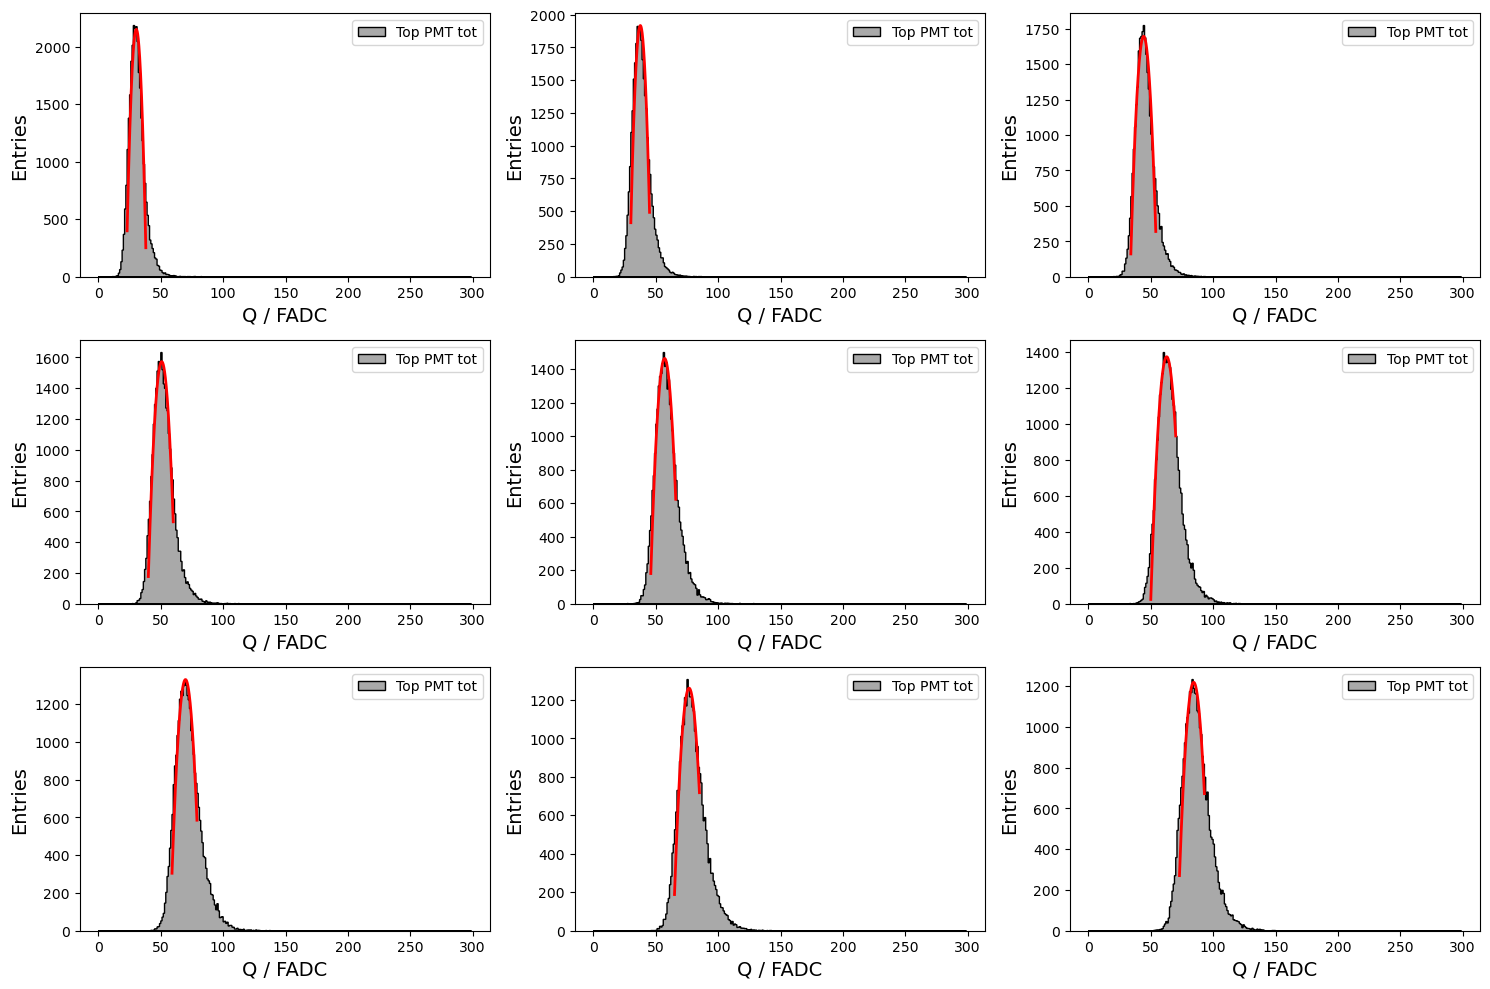

In [32]:
input_folder = '/Users/workspace/Software/Pierre_Tank/Top_Height_Scan/output/'
input_files = ['top_30cm_VEM_0.50_3', 'top_35cm_VEM_0.50_3', 'top_40cm_VEM_0.50_3', 'top_45cm_VEM_0.50_3', 'top_50cm_VEM_0.50_3', 'top_55cm_VEM_0.50_3', 'top_60cm_VEM_0.50_3', 'top_65cm_VEM_0.50_3','top_70cm_VEM_0.50_3']

min_npe = 10.

plt.subplots(3,3, figsize=(15,10))
fadc_bins_fit = np.arange(0,300,FADC_BIN_WIDTH)
fadc_bin_centers = (fadc_bins_fit[:-1] + fadc_bins_fit[1:]) / 2.

low_count_threshold_array = [20, 20, 30, 40, 40, 40, 40, 70, 70]
low_count_threshold_array_min = [10, 20, 20, 30, 30, 50, 50, 50, 50]
range_width_low = [5, 5, 10, 10, 10, 10, 10, 10, 10]
range_width_hi = [10, 10, 10, 10, 10, 10, 10, 10, 10]

fadc_peak_bin = np.zeros(len(input_files))
rel_peak_err = np.zeros(len(input_files))
fadc_peak_entries = np.zeros(len(input_files))
fadc_peak_width = np.zeros(len(input_files))

fadc_peak_pos = np.zeros(len(input_files))

fadc_min_bin = np.zeros(len(input_files))
fadc_min_entries = np.zeros(len(input_files))

for i, file in enumerate(input_files):

    plt.subplot(3,3,i+1)
    pmt_tot = load_top_sum_fadc_pmt(input_folder+file, minnpe=1)
    #plt.hist(pmt_tot, bins=fadc_bins, color='darkgray',edgecolor='black',histtype= "stepfilled", label='Top PMT tot' )

    par, d_par, range = pol2_fit(pmt_tot, fadc_bins_fit, range_low=range_width_low[i], range_hi=range_width_hi[i], low_count_threshold=low_count_threshold_array[i])
    p0_fit, p1_fit, p2_fit = par
    p0_err, p1_err, p2_err = d_par

    # Compute fitted curve
    x_fit = np.linspace(range[0], range[1], 1000)
    y_fit = pol_2(x_fit, *par)

    print('Result of Gaussian fit')

    p0_err, p1_err, p2_err = d_par
    print('p0 =',p0_fit,' +-',p0_err)
    print('p1 =',p1_fit,' +-',p1_err)
    print('p2 =',p2_fit,' +-',p1_err)

    peak_parabola = -0.5 * par[1] / par[0]
    fadc_peak_pos[i] = peak_parabola
    print('Peak position is: ',peak_parabola)

    d_peak_parabola_rel = np.sqrt( (d_par[1]/par[1])**2 + (d_par[0]/par[0])**2 )

    entries, bin, fig = plt.hist(pmt_tot, bins=fadc_bins_fit, color='darkgray',edgecolor='black',histtype= "stepfilled", label='Top PMT tot' )
    #plt.plot(x_fit, y_fit, linewidth=2, label=f'Fit: μ={mu_fit:.2f}, σ={sigma_fit:.2f}',color='red')
    plt.plot(x_fit, y_fit, linewidth=2, color='red')
    plt.legend()
    plt.yscale('linear')
    plt.xlabel('Q / FADC',size=14)
    plt.ylabel('Entries',size=14)

    fadc_peak_bin[i] = np.digitize(peak_parabola, fadc_bins_fit) - 1
    fadc_peak_entries[i] = entries[np.digitize(peak_parabola, fadc_bins_fit) - 1]

    ymax = - par[1]**2/(4*par[0]) + par[2]

    a = par[0]
    b = par[1]
    c = par[2] - ymax / 2.

    fwhm = np.sqrt(b**2 - 4 * a * c) / np.abs(a) 

    print('Peak width is : ',fwhm)

    fadc_min = find_valley(pmt_tot, low_threshold=low_count_threshold_array_min[i], peak_position=peak_parabola)
    print('Found minimum at ',fadc_min,'\n')
    fadc_min_bin[i] = np.digitize(fadc_min, fadc_bins_fit) - 1
    fadc_min_entries[i] = entries[np.digitize(fadc_min, fadc_bins_fit) -1]
#
    c = par[2] - fadc_min_entries[i]
    w_min = np.sqrt(b**2 - 4 * a * c) / np.abs(a) 
#
    print('Width at peak minimum: ',w_min,'\n')
#
    fadc_peak_width[i] = w_min


plt.tight_layout()
#plt.savefig('/Users/workspace/Software/Pierre_Tank/Top_Height_Scan/plots/top_height_fit_pol2_PE.pdf')


In [33]:
print(fadc_peak_bin)
print(fadc_peak_entries)

[30. 37. 44. 50. 57. 62. 69. 76. 84.]
[2173. 1885. 1772. 1632. 1415. 1341. 1322. 1250. 1189.]


Max coordinates ( 30.5 ,  2173.0 )
Max coordinates ( 37.5 ,  1885.0 )
Max coordinates ( 44.5 ,  1772.0 )
Max coordinates ( 50.5 ,  1632.0 )
Max coordinates ( 57.5 ,  1415.0 )
Max coordinates ( 62.5 ,  1341.0 )
Max coordinates ( 69.5 ,  1322.0 )
Max coordinates ( 76.5 ,  1250.0 )
Max coordinates ( 84.5 ,  1189.0 )


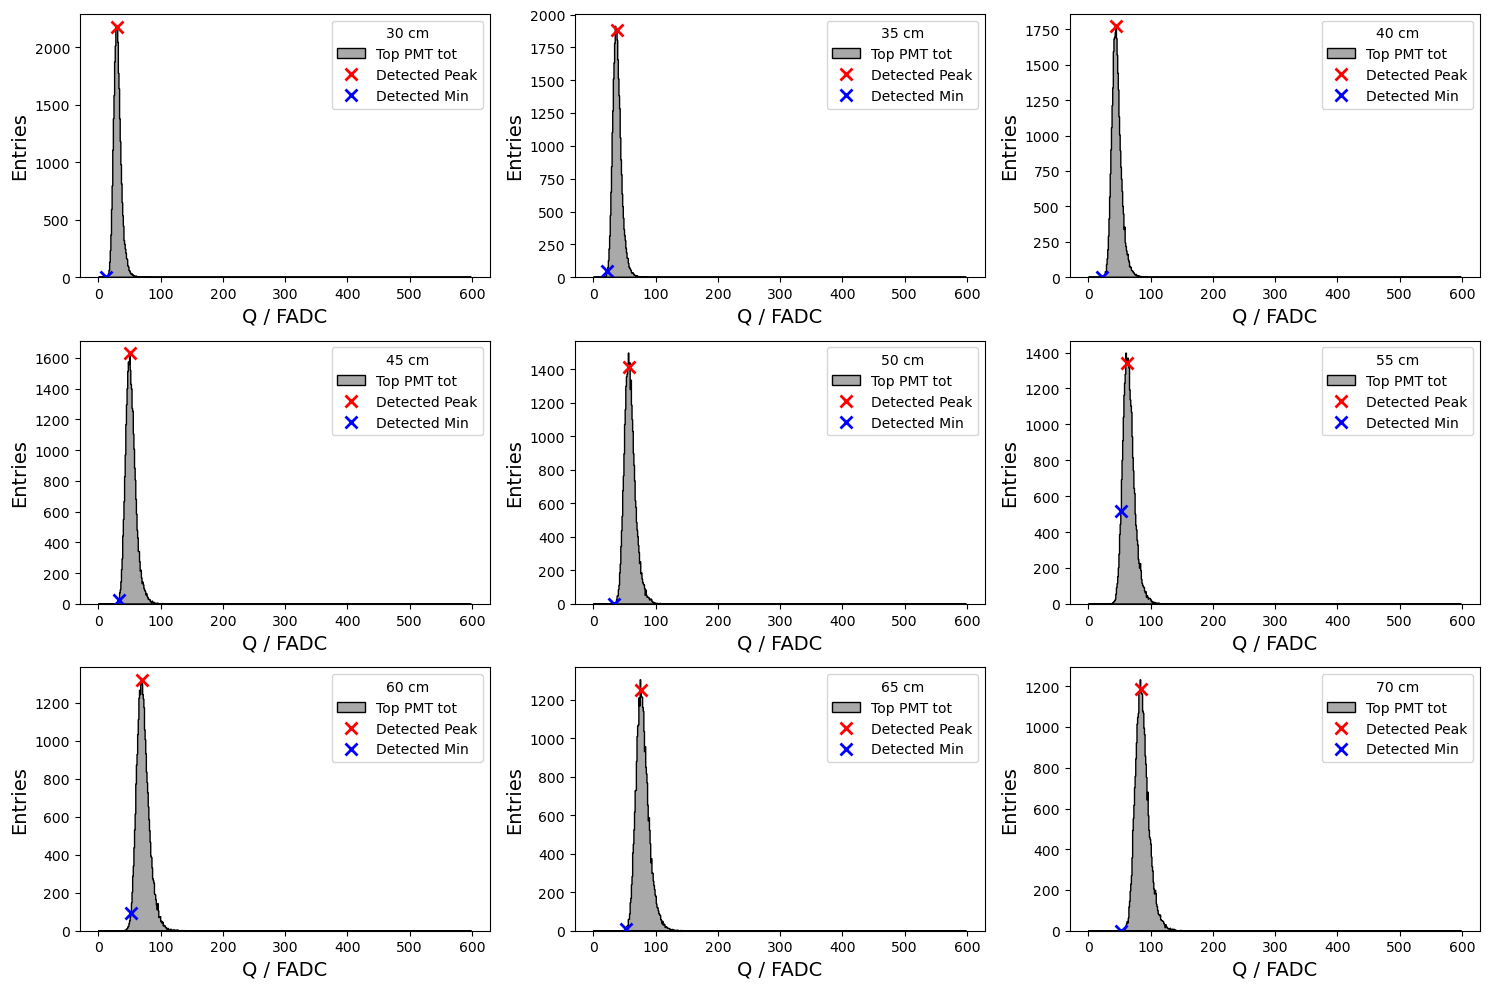

In [34]:
plt.subplots(3,3, figsize=(15,10))
fadc_bins_fit = np.arange(0,600,FADC_BIN_WIDTH)

leg_title = ['30 cm','35 cm','40 cm','45 cm','50 cm','55 cm','60 cm','65 cm','70 cm']

for i, file in enumerate(input_files):

    plt.subplot(3,3,i+1)
    pmt_tot = load_top_sum_fadc_pmt(input_folder+file, minnpe=10)
    #plt.hist(pmt_tot, bins=fadc_bins, color='darkgray',edgecolor='black',histtype= "stepfilled", label='Top PMT tot' )

    i_peak_bin = int(fadc_peak_bin[i])
    i_min_bin = int(fadc_min_bin[i])

    print('Max coordinates (',fadc_bin_centers[i_peak_bin],', ',fadc_peak_entries[i],')')
    entries, bin, fig = plt.hist(pmt_tot, bins=fadc_bins_fit, color='darkgray',edgecolor='black',histtype= "stepfilled", label='Top PMT tot' )
    plt.plot(fadc_bin_centers[i_peak_bin], fadc_peak_entries[i], 'rx', label='Detected Peak', ms=8, mew=2)
    plt.plot(fadc_bin_centers[i_min_bin], fadc_min_entries[i], 'bx', label='Detected Min',ms=8, mew=2)

    plt.legend(title = leg_title[i])
    plt.yscale('linear')
    plt.xlabel('Q / FADC',size=14)
    plt.ylabel('Entries',size=14)


plt.tight_layout()

#plt.savefig('/Users/workspace/Software/Pierre_Tank/Top_Height_Scan/plots/top_height_scan_max_min_pol2_PE.pdf')

In [35]:
print(fadc_peak_pos)
np.save('/Users/workspace/Software/Pierre_Tank/Top_Height_Scan/output/calibration_arrays/top_PMT_VEM_FADC.npy',fadc_peak_pos)


[30.34882817 37.60122995 44.27194069 50.73371935 57.05459173 62.72940065
 69.79832776 76.6840607  84.37027556]
